In [36]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import RFE

In [37]:
X = pd.read_csv("X_train.csv")
X = X.drop(columns=["id"])

In [38]:
y = pd.read_csv("y_train.csv")['y']

In [39]:
X_test = pd.read_csv("X_test.csv")
ids = X_test["id"]
X_test = X_test.drop(columns=["id"])

Remove constant columns

In [40]:
X_test = X_test.loc[:, X.var() != 0.0]
X = X.loc[:, X.var() != 0.0]

Remove highly correlated features

In [41]:
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Removed columns: ", len(to_drop))
# Drop features 
X.drop(to_drop, axis=1, inplace=True)
X_test.drop(to_drop, axis=1, inplace=True)

Removed columns:  53


Scale

In [42]:
transformer = RobustScaler()
X = transformer.fit_transform(X)
X_test = transformer.transform(X_test)

In [43]:
transformer.fit(np.expand_dims(y, axis=-1))
y_s = transformer.transform(np.expand_dims(y, axis=-1))

Impute median

In [44]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X = imp_median.fit_transform(X)
X_test = imp_median.transform(X_test)

In [45]:
y = y.to_numpy()

Feature selection with Lasso

In [46]:
def lasso_select(train, val, target, alpha=1):
    
    clf = Lasso(alpha=alpha)
    clf.fit(train, target)
    coef = clf.coef_
    
    # select features with non-zero lasso coefficients
    sel = np.arange(train.shape[1])[coef != 0]
    print(sel)
    train = train[:, coef != 0]
    val = val[:, coef != 0]
    print("Selected features: " ,np.count_nonzero(clf.coef_))
    
    return train, val

In [78]:
X_s, X_test_s = lasso_select(X, X_test, y, alpha=0.56)

[ 90 112 127 151 185 219 306 384 388 429 454 473 571 598 622 662 676 691
 770 771]
Selected features:  20


Handcrafting the feature map

In [79]:
sel = np.logical_and((X_s[:, 1] + 0.6) > 0, (X_s[:, 8] + 1) > 0)
print("Removed: ", (np.logical_or((X_s[:, 1] + 0.6) < 0,(X_s[:, 8] + 1) < 0)).sum())
# removing the negative one from 1 and 8 seems to remove the negative ones from all other log shaped features too
# that is really nice, because we have to remove only a few
y_t = y[sel]
# y_s = y_s[sel]
X_t = X_s[sel]
X_t[:, 1] = np.log(X_t[:,1] + 0.61)
X_t[:, 3] = np.log(X_t[:,3] + 1.2)
X_t[:, 8] = np.log(X_t[:,8] + 1)
X_t[:, 9] = np.log(X_t[:,9] + 2)
X_t[:, 11] = np.log(X_t[:,11] + 1)
X_t[:, 13] = np.log(X_t[:,13] + 1)

# this is one is special, it has 2 clusters
# some samples of this feature got shifted, so we shift it back
# not sure about this

X_t[:, 17][X_t[:,17] > 7] = X_t[:, 17][X_t[:,17] > 7] - 13

Removed:  27


In [80]:
# we have to apply the same transformations to the test data set
X_test_s.setflags(write=1)
X_test_s[:, 1] = np.log(X_test_s[:,1] + 0.61)
X_test_s[:, 3] = np.log(X_test_s[:,3] + 1.2)
X_test_s[:, 8] = np.log(X_test_s[:,8] + 1)
X_test_s[:, 9] = np.log(X_test_s[:,9] + 2)
X_test_s[:, 11] = np.log(X_test_s[:,11] + 1)
X_test_s[:, 13] = np.log(X_test_s[:,13] + 1)
X_test_s[:, 17][X_test_s[:,17] > 7] = X_test_s[:, 17][X_test_s[:,17] > 7] - 13

Outlier Detection

In [81]:
dbscan = DBSCAN(eps=3.2, min_samples=40)
dbscan.fit(X_t)
X_tt = X_t[dbscan.labels_ != -1]
y_tt = y_t[dbscan.labels_ != -1]
print("Outliers removed: ", (dbscan.labels_ == -1).sum())

Outliers removed:  58


Cross Validation

In [82]:
k = 10
n_folds = 5

rkf = RepeatedKFold(n_splits=n_folds, n_repeats=k)

r2_val_ridge, r2_train_ridge = 0, 0
r2_val_xgb, r2_train_xgb = 0, 0
r2_val_lgb, r2_train_lgb = 0, 0
r2_val_gbr, r2_train_gbr = 0, 0
r2_val_cat, r2_train_cat = 0, 0

for train_index, val_index in rkf.split(X_tt):
    
    X_train, X_val = X_tt[train_index], X_tt[val_index]
    y_train, y_val = y_tt[train_index], y_tt[val_index]

    # fit models

    ridge = Ridge(alpha=1)
    #xgb = XGBRegressor(max_depth=2, eta=0.1, reg_lambda=5)
    #lgb = LGBMRegressor(max_depth=2, reg_lambda=1, n_estimators=400)
    #gbr = GradientBoostingRegressor(max_depth=2)
    #cat = CatBoostRegressor(verbose=False, allow_writing_files=False)

    ridge.fit(X_train, y_train)
    #xgb.fit(X_train, y_train)
    #lgb.fit(X_train, y_train)
    #gbr.fit(X_train, y_train)
    #cat.fit(X_train, y_train)

    r2_val_ridge += r2_score(y_val, ridge.predict(X_val))
    #r2_val_xgb += r2_score(y_val, xgb.predict(X_val))
    #r2_val_lgb += r2_score(y_val, lgb.predict(X_val))
    #r2_val_gbr += r2_score(y_val, gbr.predict(X_val))
    #r2_val_cat += r2_score(y_val, cat.predict(X_val))

    r2_train_ridge += r2_score(y_train, ridge.predict(X_train))
    #r2_train_xgb += r2_score(y_train, xgb.predict(X_train))
    #r2_train_lgb += r2_score(y_train, lgb.predict(X_train))
    #r2_train_gbr += r2_score(y_train, gbr.predict(X_train))
    #r2_train_cat += r2_score(y_train, cat.predict(X_train))

Validation Scores

In [83]:
print("Ridge:", r2_val_ridge/(n_folds*k))
#print("XGB:", r2_val_xgb/(n_folds*k))
#print("LGB:", r2_val_lgb/(n_folds*k))
#print("GBR:", r2_val_gbr/(n_folds*k))
#print("Cat", r2_val_cat/(n_folds*k))

Ridge: 0.5832200361326946


Train Scores

In [84]:
print("Ridge:", r2_train_ridge/(n_folds*k))
#print("XGB:", r2_train_xgb/(n_folds*k))
#print("LGB:", r2_train_lgb/(n_folds*k))
#print("GBR:", r2_train_gbr/(n_folds*k))
#print("Cat:", r2_train_cat/(n_folds*k))

Ridge: 0.6083334140562902


Submission

In [85]:
ridge = Ridge(alpha=1)
ridge.fit(X_tt, y_tt)
sub = ridge.predict(X_test_s)

In [86]:
pd.DataFrame({"id": ids, "y": sub}).to_csv("sub_ridge.csv", index=False)

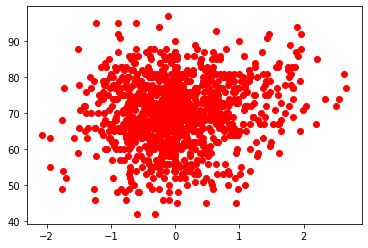

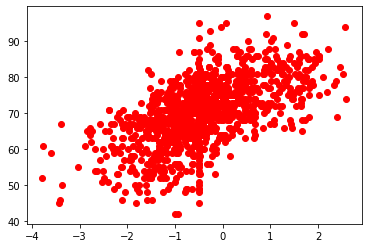

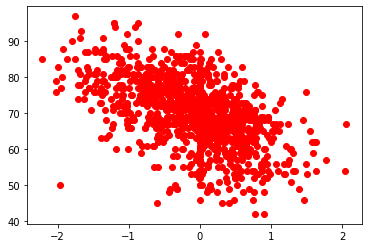

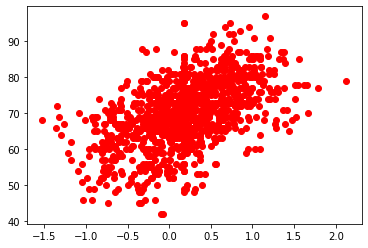

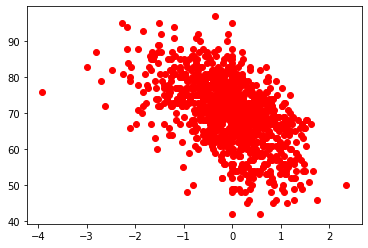

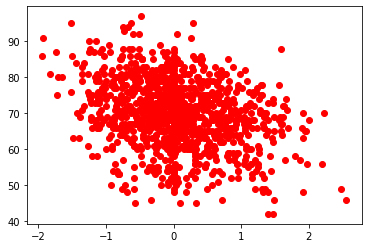

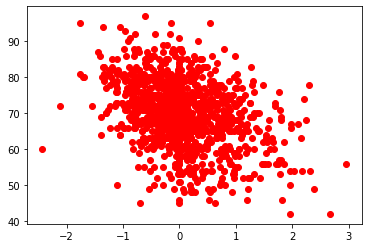

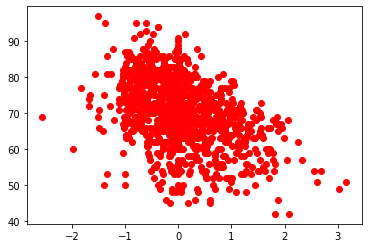

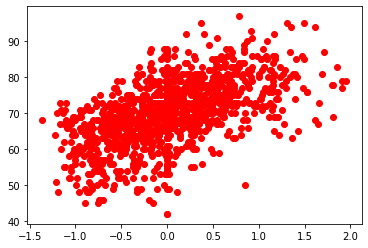

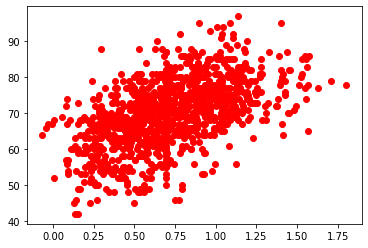

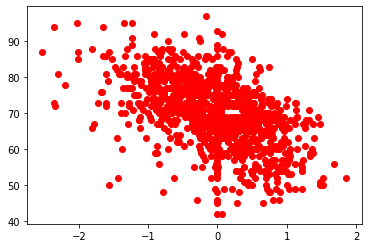

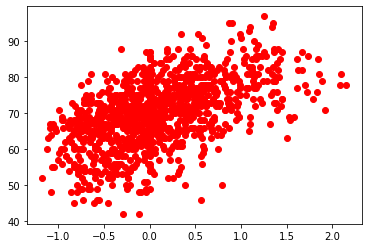

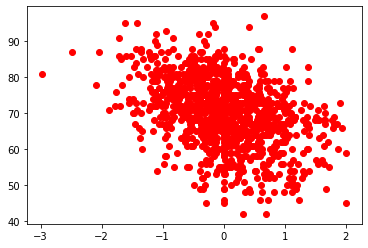

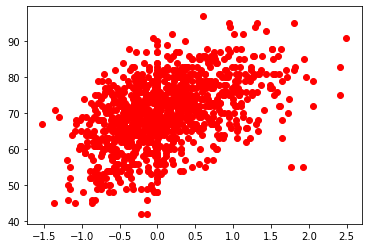

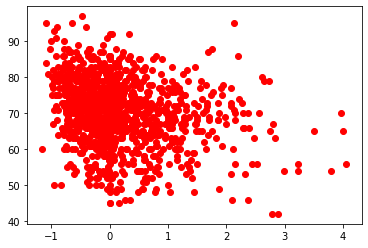

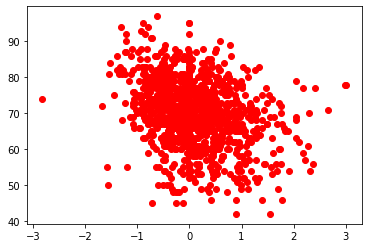

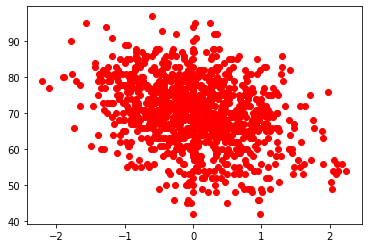

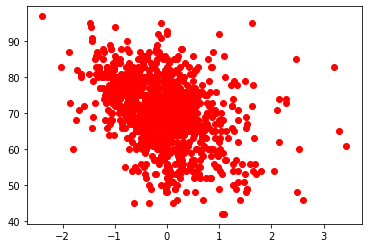

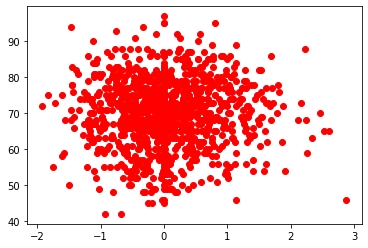

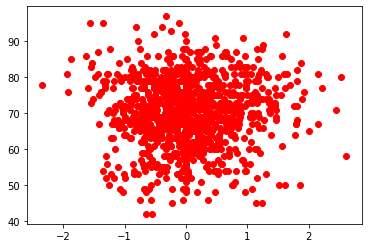

In [92]:
# after DBSCAN outlier removal there are still some outliers left
# -> maybe fit GMM to each (feature, target) pair and remove some of the persistent outliers?
for i in range(20):
        plt.plot(X_tt[:, i], y_tt, 'ro')
        plt.show()

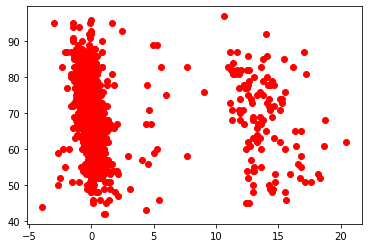

In [63]:
# this one has 2 clusters, what to do? I shifted everything above a threshold back, but maybe this is not the best approach
plt.plot(X_s[:, 17], y, 'ro')